In [1]:

# BLOCO 1 - COLETA E CARREGAMENTO DAS BASES

# Carregando os Arquivos CSV
import pandas as pd

print("\nCarregando os arquivos CSV a partir do GitHub...")

# URLs das bases de dados no repositório
url_cadastro = 'https://raw.githubusercontent.com/2025-2-NCC4/Projeto1/refs/heads/main/documentos/Entrega%201/Projeto%20Interdisciplinar%20Ci%C3%AAncia%20de%20Dados/Base%20de%20Dados/Base_Cadastral_de_Players.csv'
url_transacoes = 'https://raw.githubusercontent.com/2025-2-NCC4/Projeto1/refs/heads/main/documentos/Entrega%201/Projeto%20Interdisciplinar%20Ci%C3%AAncia%20de%20Dados/Base%20de%20Dados/Base_de_Transacoes_e_Cupons_Capturados.csv'
url_pedestres = 'https://raw.githubusercontent.com/2025-2-NCC4/Projeto1/refs/heads/main/documentos/Entrega%201/Projeto%20Interdisciplinar%20Ci%C3%AAncia%20de%20Dados/Base%20de%20Dados/Base_Simulada_de_Pedestres_Av__Paulista.csv'
url_massa_teste = 'https://raw.githubusercontent.com/2025-2-NCC4/Projeto1/refs/heads/main/documentos/Entrega%201/Projeto%20Interdisciplinar%20Ci%C3%AAncia%20de%20Dados/Base%20de%20Dados/Massa_de_Teste_com_Lojas_e_Valores.csv'

# Tentativa de carregamento
try:
    df_cadastro = pd.read_csv(url_cadastro, delimiter=';')
    df_transacoes = pd.read_csv(url_transacoes, delimiter=';')
    df_pedestres = pd.read_csv(url_pedestres, delimiter=';')
    df_massa_teste = pd.read_csv(url_massa_teste, delimiter=';')

    print("✅ Todos os arquivos foram carregados com sucesso.")
    print(f"Base Cadastral: {df_cadastro.shape}")
    print(f"Base de Transações: {df_transacoes.shape}")
    print(f"Base de Pedestres: {df_pedestres.shape}")
    print(f"Massa de Teste: {df_massa_teste.shape}")

except Exception as e:
    print(f"❌ Ocorreu um erro ao carregar os dados da URL: {e}")
    raise SystemExit



Carregando os arquivos CSV a partir do GitHub...
✅ Todos os arquivos foram carregados com sucesso.
Base Cadastral: (10000, 11)
Base de Transações: (100000, 12)
Base de Pedestres: (100000, 15)
Massa de Teste: (10000, 11)


In [2]:
# Parte 2: Verificação da Qualidade e Limpeza dos Dados

import numpy as np

# 2.1 Tratamento do DataFrame de Cadastro (df_cadastro)
print("\nTratando o DataFrame: Cadastro de Players")

# Normalizar coluna 'celular' (remover tudo que não for dígito)
if 'celular' in df_cadastro.columns:
    df_cadastro['celular'] = df_cadastro['celular'].astype(str).str.replace(r'\D+', '', regex=True).str.strip()

print("\nContagem de valores ausentes por coluna:")
print(df_cadastro.isnull().sum())

# Converter data_nascimento para datetime com coercion
if 'data_nascimento' in df_cadastro.columns:
    df_cadastro['data_nascimento'] = pd.to_datetime(df_cadastro['data_nascimento'], errors='coerce', dayfirst=True)

# Se 'idade' não existir ou estiver incoerente, calcular a partir de data_nascimento
if 'idade' not in df_cadastro.columns or df_cadastro['idade'].dtype == object:
    if 'data_nascimento' in df_cadastro.columns:
        hoje = pd.Timestamp.now().normalize()
        df_cadastro['idade'] = ((hoje - df_cadastro['data_nascimento']).dt.days // 365).clip(lower=0)
        print("Coluna 'idade' (re)criada a partir de 'data_nascimento' quando aplicável.")

# duplicadas
duplicated_rows = df_cadastro.duplicated().sum()
print(f"\nNúmero de linhas duplicadas em cadastro: {duplicated_rows}")

# categorical checks
for col in ['sexo', 'cidade_residencial']:
    if col in df_cadastro.columns:
        print(f"\nValores únicos em {col}:")
        print(df_cadastro[col].value_counts().head(10))

# 2.2 Tratamento do DataFrame de Transações (df_transacoes)
print("\nTratando o DataFrame: Transações e Cupons")
# Normalizar celular
if 'celular' in df_transacoes.columns:
    df_transacoes['celular'] = df_transacoes['celular'].astype(str).str.replace(r'\D+', '', regex=True).str.strip()

print(df_transacoes.isnull().sum())

# Converter datas
if 'data' in df_transacoes.columns:
    df_transacoes['data'] = pd.to_datetime(df_transacoes['data'], errors='coerce', dayfirst=True)

# Função robusta para converter valores monetários com milhares e decimais (ex: "1.234,56" ou "1234.56")
def parse_monetary_column(s):
    s = s.astype(str).str.strip().replace('nan', np.nan)
    # remover espaços
    s = s.str.replace(' ', '', regex=False)

    def convert(x):
        if pd.isna(x): return np.nan
        if (',' in x) and ('.' in x):

            return float(x.replace('.', '').replace(',', '.'))
        if ',' in x and '.' not in x:
            return float(x.replace(',', '.'))
        try:
            return float(x)
        except:
            return np.nan
    return s.apply(convert)

for col in ['valor_cupom','repasse_picmoney']:
    if col in df_transacoes.columns:
        df_transacoes[col+'_clean'] = parse_monetary_column(df_transacoes[col])

# duplicatas
print("Duplicatas em transacoes:", df_transacoes.duplicated().sum())

# 2.3 Tratamento do DataFrame de Pedestres (df_pedestres)
print("\nTratando o DataFrame: Pedestres Av. Paulista")
print(df_pedestres.isnull().sum())

# Limpeza lat/long
def clean_coordinate(series):
    s = series.astype(str).str.strip().replace('nan', np.nan)
    s = s.str.replace(' ', '', regex=False).str.replace(',', '.', regex=False)
    def fix(x):
        if pd.isna(x): return np.nan
        parts = x.split('.')
        if len(parts) <= 2:
            return x

        return ''.join(parts[:-1]) + '.' + parts[-1]
    s = s.apply(fix)
    return pd.to_numeric(s, errors='coerce')

for col in ['latitude','longitude']:
    if col in df_pedestres.columns:
        df_pedestres[col+'_clean'] = clean_coordinate(df_pedestres[col])

# horario
if 'horario' in df_pedestres.columns:
    df_pedestres['horario_clean'] = pd.to_datetime(df_pedestres['horario'], errors='coerce').dt.time

# duplicatas
print("Duplicatas em pedestres:", df_pedestres.duplicated().sum())

# 2.4 Massa de Teste
print("\nTratando o DataFrame: Massa de Teste")
print(df_massa_teste.isnull().sum())
print("Duplicatas em massa_teste:", df_massa_teste.duplicated().sum())

print("\nLimpeza inicial concluída.")



Tratando o DataFrame: Cadastro de Players

Contagem de valores ausentes por coluna:
celular                     0
data_nascimento             0
idade                       0
sexo                        0
cidade_residencial          0
bairro_residencial          0
cidade_trabalho          3969
bairro_trabalho          3969
cidade_escola            6932
bairro_escola            6932
categoria_frequentada       0
dtype: int64

Número de linhas duplicadas em cadastro: 0

Valores únicos em sexo:
sexo
Outro        3356
Masculino    3322
Feminino     3322
Name: count, dtype: int64

Valores únicos em cidade_residencial:
cidade_residencial
São Paulo    8967
Cardoso        16
Ramos          15
Sales          14
Silva          13
Costa          13
Oliveira       12
Viana          11
da Cruz        11
Gomes          11
Name: count, dtype: int64

Tratando o DataFrame: Transações e Cupons
celular                          0
data                             0
hora                             0
nome_e

/tmp/ipython-input-978938471.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pedestres['horario_clean'] = pd.to_datetime(df_pedestres['horario'], errors='coerce').dt.time


Duplicatas em pedestres: 0

Tratando o DataFrame: Massa de Teste
numero_celular    0
data_captura      0
tipo_cupom        0
tipo_loja         0
local_captura     0
latitude          0
longitude         0
nome_loja         0
endereco_loja     0
valor_compra      0
valor_cupom       0
dtype: int64
Duplicatas em massa_teste: 0

Limpeza inicial concluída.



Análise: Cadastro de Usuários
count    10000.000000
mean        52.793500
std         21.568963
min         16.000000
25%         34.000000
50%         53.000000
75%         71.000000
max         91.000000
Name: idade, dtype: float64


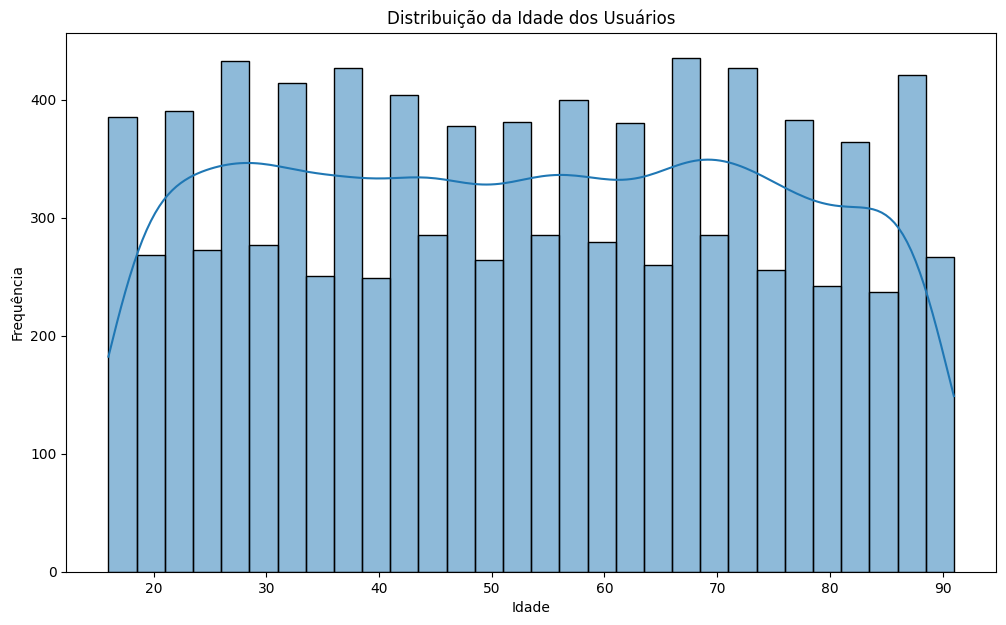

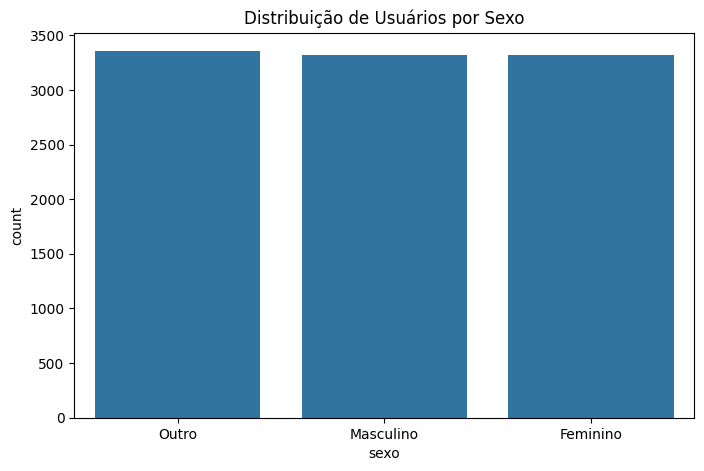

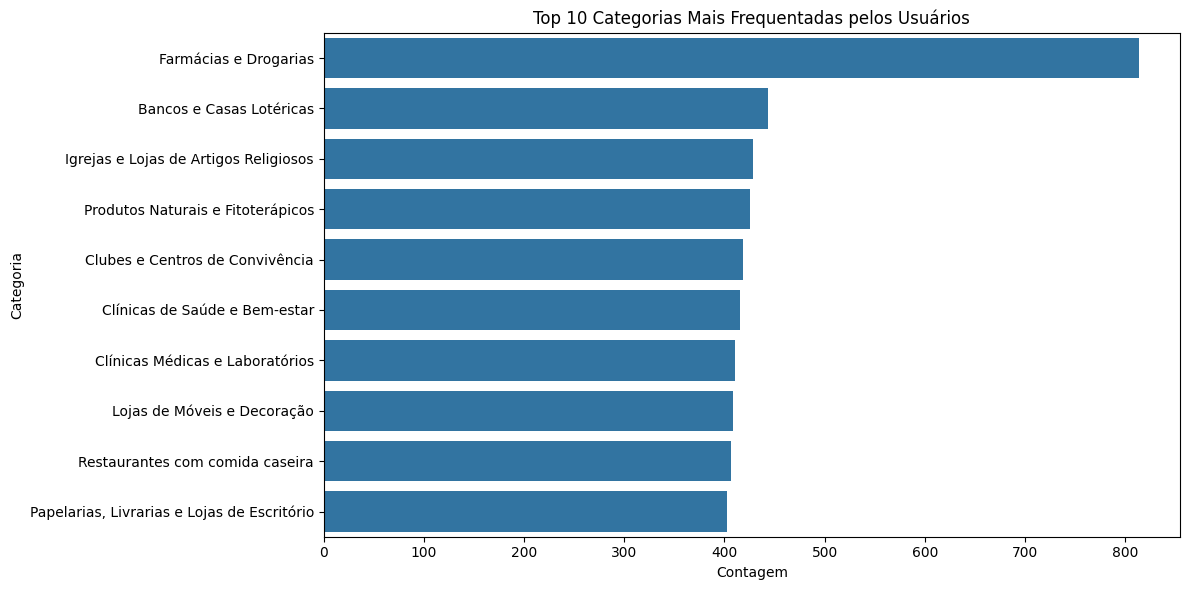


Análise: Transações


,valor_cupom_clean,repasse_picmoney_clean
count,100000.000000,100000.000000
mean,550.489585,70.474739
std,259.410143,90.823519
min,100.010000,1.070000
25%,326.627500,16.180000
50%,550.265000,32.815000
75%,774.910000,80.160000
max,999.960000,497.320000


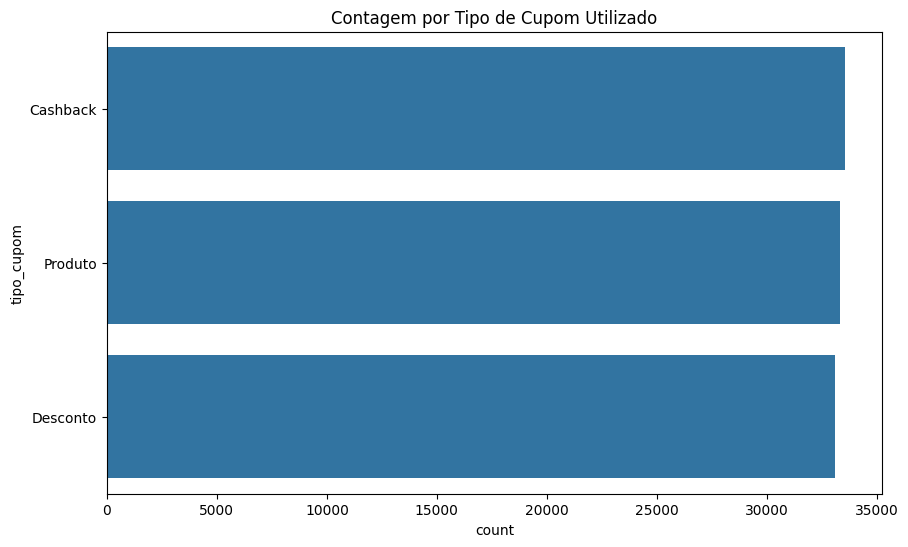

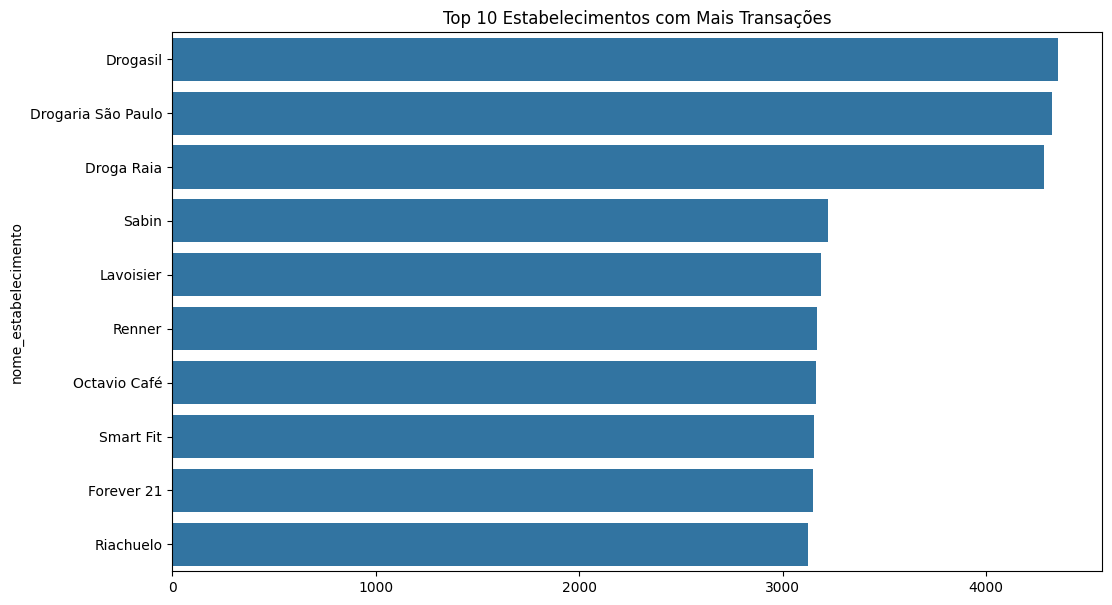


Análise: Pedestres


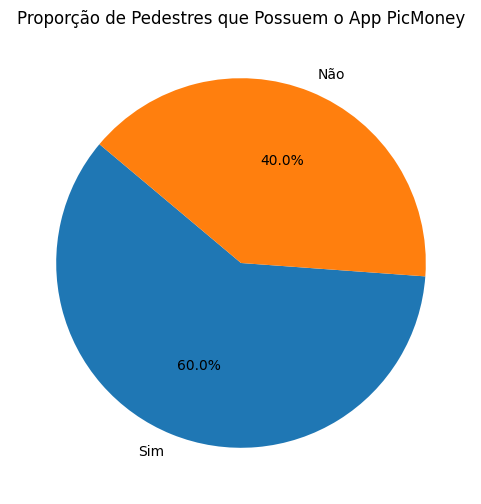

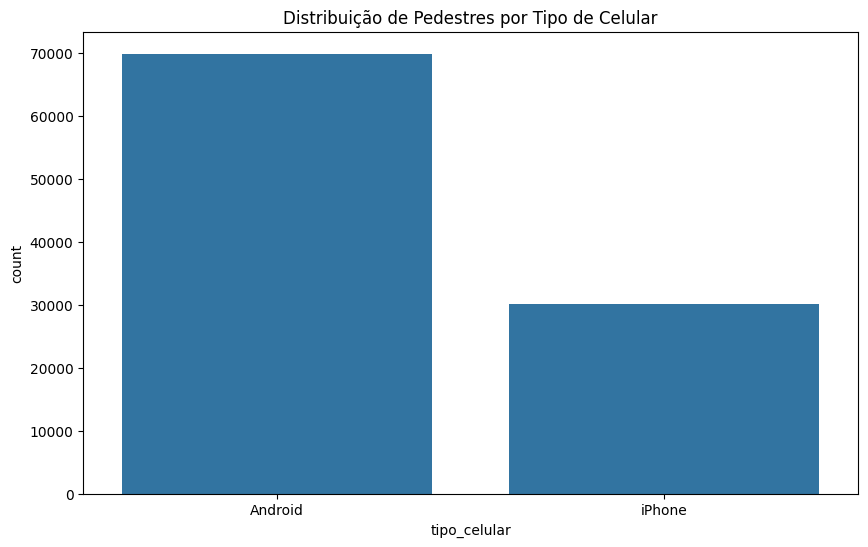


Análise exploratória concluída.


In [3]:
# Parte 3: Análise Exploratória de Dados
import seaborn as sns
import matplotlib.pyplot as plt

# 3.1 Cadastro
print("\nAnálise: Cadastro de Usuários")

if 'idade' in df_cadastro.columns:
    print(df_cadastro['idade'].describe())
    plt.figure(figsize=(12,7))
    sns.histplot(df_cadastro['idade'].dropna(), bins=30, kde=True)
    plt.title('Distribuição da Idade dos Usuários')
    plt.xlabel('Idade')
    plt.ylabel('Frequência')
    plt.show()

if 'sexo' in df_cadastro.columns:
    plt.figure(figsize=(8,5))
    sns.countplot(x='sexo', data=df_cadastro, order=df_cadastro['sexo'].value_counts().index)
    plt.title('Distribuição de Usuários por Sexo')
    plt.show()

if 'categoria_frequentada' in df_cadastro.columns:
    top_10_categorias = df_cadastro['categoria_frequentada'].value_counts().nlargest(10)
    plt.figure(figsize=(12,6))
    sns.barplot(y=top_10_categorias.index, x=top_10_categorias.values, orient='h')
    plt.title('Top 10 Categorias Mais Frequentadas pelos Usuários')
    plt.xlabel('Contagem')
    plt.ylabel('Categoria')
    plt.tight_layout()
    plt.show()

# 3.2 Transações
print("\nAnálise: Transações")
if 'valor_cupom_clean' in df_transacoes.columns and 'repasse_picmoney_clean' in df_transacoes.columns:
    display(df_transacoes[['valor_cupom_clean','repasse_picmoney_clean']].describe())

if 'tipo_cupom' in df_transacoes.columns:
    plt.figure(figsize=(10,6))
    sns.countplot(y='tipo_cupom', data=df_transacoes, order=df_transacoes['tipo_cupom'].value_counts().index)
    plt.title('Contagem por Tipo de Cupom Utilizado')
    plt.show()

if 'nome_estabelecimento' in df_transacoes.columns:
    top_10_estabelecimentos = df_transacoes['nome_estabelecimento'].value_counts().nlargest(10)
    plt.figure(figsize=(12,7))
    sns.barplot(y=top_10_estabelecimentos.index, x=top_10_estabelecimentos.values, orient='h')
    plt.title('Top 10 Estabelecimentos com Mais Transações')
    plt.show()

# 3.3 Pedestres
print("\nAnálise: Pedestres")
if 'possui_app_picmoney' in df_pedestres.columns:
    app_counts = df_pedestres['possui_app_picmoney'].value_counts(dropna=False)
    plt.figure(figsize=(6,6))
    plt.pie(app_counts, labels=app_counts.index.astype(str), autopct='%1.1f%%', startangle=140)
    plt.title('Proporção de Pedestres que Possuem o App PicMoney')
    plt.show()

if 'tipo_celular' in df_pedestres.columns:
    plt.figure(figsize=(10,6))
    sns.countplot(x='tipo_celular', data=df_pedestres, order=df_pedestres['tipo_celular'].value_counts().index)
    plt.title('Distribuição de Pedestres por Tipo de Celular')
    plt.show()

print("\nAnálise exploratória concluída.")


Merge realizado. Dimensões: (100011, 26)
        sexo  valor_cupom_clean
0   Feminino         550.457431
1  Masculino         551.275658
2      Outro         549.717817


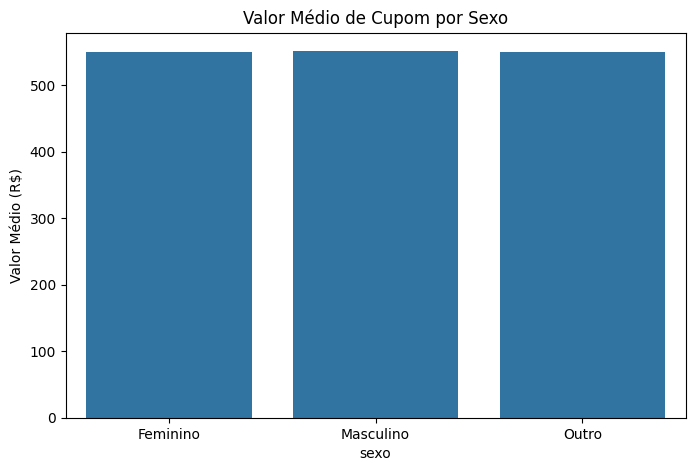

/tmp/ipython-input-2676377520.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  valor_medio_por_idade = df_merged.groupby('faixa_etaria')['valor_cupom_clean'].mean().reset_index()


,faixa_etaria,valor_cupom_clean
0,0-18,546.316466
1,19-25,547.203876
2,26-35,550.711409
3,36-50,553.278122
4,51-65,552.406382
5,65+,548.824723


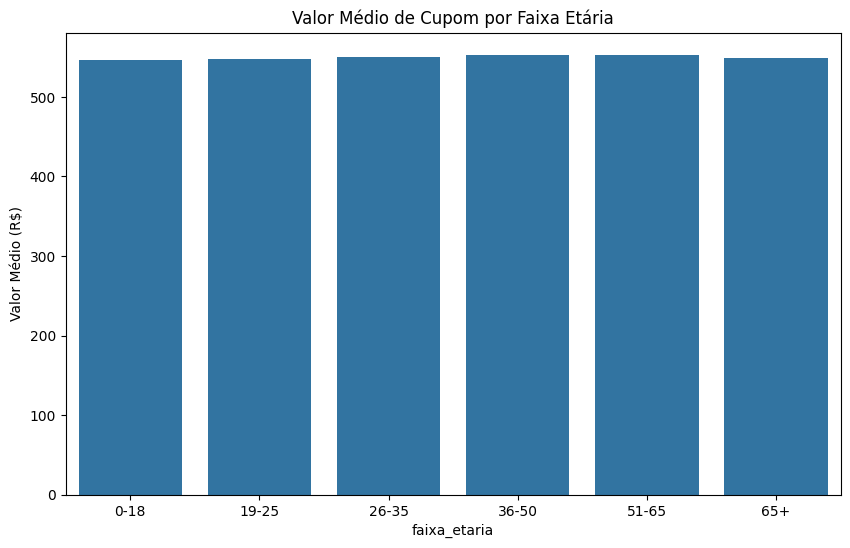


Análise combinada concluída.


In [4]:
# Parte 4: Junção e Análise Combinada


if 'celular' in df_cadastro.columns and 'celular' in df_transacoes.columns:
    cad = df_cadastro.copy()
    tra = df_transacoes.copy()
    cad['__cel'] = cad['celular'].astype(str).str.replace(r'\D+', '', regex=True).str.strip()
    tra['__cel'] = tra['celular'].astype(str).str.replace(r'\D+', '', regex=True).str.strip()
    df_merged = pd.merge(cad, tra, left_on='__cel', right_on='__cel', how='inner', suffixes=('_cad','_tra'))
    print("Merge realizado. Dimensões:", df_merged.shape)
else:
    raise RuntimeError("Coluna 'celular' não encontrada em cadastro ou transacoes.")

# 4.2 Valor médio por sexo
if 'sexo' in df_merged.columns and 'valor_cupom_clean' in df_merged.columns:
    df_merged['valor_cupom_clean'] = df_merged['valor_cupom_clean'].astype(float)
    valor_medio_por_sexo = df_merged.groupby('sexo')['valor_cupom_clean'].mean().reset_index()
    print(valor_medio_por_sexo)
    import seaborn as sns
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,5))
    sns.barplot(x='sexo', y='valor_cupom_clean', data=valor_medio_por_sexo)
    plt.title('Valor Médio de Cupom por Sexo')
    plt.ylabel('Valor Médio (R$)')
    plt.show()

# 4.3 Valor médio por faixa etária
if 'idade' in df_merged.columns:
    bins = [0, 18, 25, 35, 50, 65, 120]
    labels = ['0-18','19-25','26-35','36-50','51-65','65+']
    df_merged['faixa_etaria'] = pd.cut(df_merged['idade'].fillna(-1), bins=bins, labels=labels, right=False)
    valor_medio_por_idade = df_merged.groupby('faixa_etaria')['valor_cupom_clean'].mean().reset_index()
    display(valor_medio_por_idade)
    plt.figure(figsize=(10,6))
    sns.barplot(x='faixa_etaria', y='valor_cupom_clean', data=valor_medio_por_idade)
    plt.title('Valor Médio de Cupom por Faixa Etária')
    plt.ylabel('Valor Médio (R$)')
    plt.show()

print("\nAnálise combinada concluída.")


In [6]:
# PARTE 5: PREPARAR OS DADOS
import pandas as pd
import numpy as np

print("PARTE 5: PREPARAR OS DADOS")


for var in ['df_cadastro','df_transacoes','df_pedestres','df_massa_teste']:
    if var not in globals():
        raise RuntimeError(f"Variável {var} não encontrada. Execute os blocos anteriores.")


if 'df_merged' not in globals():
    print("df_merged não encontrado. Criando agora a junção básica...")
    cad = df_cadastro.copy()
    tra = df_transacoes.copy()
    cad['__cel'] = cad['celular'].astype(str).str.replace(r'\D+', '', regex=True).str.strip()
    tra['__cel'] = tra['celular'].astype(str).str.replace(r'\D+', '', regex=True).str.strip()
    df_merged = pd.merge(cad, tra, left_on='__cel', right_on='__cel', how='inner', suffixes=('_cad','_tra'))

# Seleção de colunas relevantes
colunas_relevantes = [
    '__cel', 'sexo', 'idade', 'cidade_residencial',
    'categoria_frequentada', 'nome_estabelecimento',
    'categoria_estabelecimento', 'valor_cupom_clean', 'repasse_picmoney_clean', 'data'
]
colunas_existentes = [c for c in colunas_relevantes if c in df_merged.columns]
df_preparado = df_merged[colunas_existentes].copy()


df_preparado = df_preparado.rename(columns={
    '__cel': 'celular',
    'valor_cupom_clean': 'valor_cupom',
    'repasse_picmoney_clean': 'repasse_picmoney'
})

# Limpeza
linhas_antes = df_preparado.shape[0]
df_preparado.drop_duplicates(inplace=True)

if 'valor_cupom' in df_preparado.columns:
    df_preparado = df_preparado[df_preparado['valor_cupom'].notna()]

if 'celular' in df_preparado.columns:
    df_preparado = df_preparado[df_preparado['celular'].notna()]
else:
    print("Warning: 'celular' column not found in df_preparado for notna() check.")

linhas_depois = df_preparado.shape[0]
print(f"{linhas_antes - linhas_depois} linhas removidas durante limpeza.")


for col in ['cidade_residencial', 'categoria_frequentada', 'nome_estabelecimento', 'categoria_estabelecimento']:
    if col in df_preparado.columns:
        df_preparado[col] = df_preparado[col].astype(str).str.lower().str.strip()

# Colunas derivadas
if 'valor_cupom' in df_preparado.columns:
    df_preparado = df_preparado[df_preparado['valor_cupom'] > 0]

# faixas de valor
if 'valor_cupom' in df_preparado.columns:
    valor_maximo = df_preparado['valor_cupom'].max()
    bins_valor = [0, 50, 200, 500, 1000, valor_maximo + 1]
    labels_valor = ['baixo','medio','alto','muito alto','premium'][:len(bins_valor)-1]
    df_preparado['faixa_valor_cupom'] = pd.cut(df_preparado['valor_cupom'], bins=bins_valor, labels=labels_valor, right=False)

# percentual repasse evitando divisão por zero
if ('repasse_picmoney' in df_preparado.columns) and ('valor_cupom' in df_preparado.columns):
    df_preparado['perc_repasse'] = np.where(df_preparado['valor_cupom']>0,
                                            (df_preparado['repasse_picmoney'] / df_preparado['valor_cupom']) * 100,
                                            np.nan)

# reset index
df_preparado.reset_index(drop=True, inplace=True)
print("DataFrame preparado com shape:", df_preparado.shape)
display(df_preparado.head())

PARTE 5: PREPARAR OS DADOS
0 linhas removidas durante limpeza.
DataFrame preparado com shape: (100011, 12)


,celular,sexo,idade,cidade_residencial,categoria_frequentada,nome_estabelecimento,categoria_estabelecimento,valor_cupom,repasse_picmoney,data,faixa_valor_cupom,perc_repasse
0,11914095506,Masculino,55,são paulo,farmácias e drogarias,just run,academias e studios fitness,241.34,111.80,2025-07-23,alto,46.324687
1,11914095506,Masculino,55,são paulo,farmácias e drogarias,burger king,lanchonetes e fast-food,275.72,13.79,2025-07-11,alto,5.001451
2,11914095506,Masculino,55,são paulo,farmácias e drogarias,forever 21,lojas de eletrodomésticos e utilidades domésticas,962.69,130.45,2025-07-03,muito alto,13.550572
3,11914095506,Masculino,55,são paulo,farmácias e drogarias,extra,supermercados de bairro e mercadinhos,615.98,30.80,2025-07-19,muito alto,5.000162
4,11914095506,Masculino,55,são paulo,farmácias e drogarias,drogasil,lojas de roupas e calçados,714.09,35.70,2025-07-05,muito alto,4.999370


In [7]:
# DASHBOARD / ANALISE VISUAL
import plotly.express as px
import plotly.graph_objects as go

template_visual = "plotly_dark"

# verificações
if 'df_preparado' not in globals():
    raise RuntimeError("df_preparado não encontrado. Execute a preparação antes.")

# KPIs
receita_total = df_preparado['valor_cupom'].sum() if 'valor_cupom' in df_preparado.columns else 0
comissao_total = df_preparado['repasse_picmoney'].sum() if 'repasse_picmoney' in df_preparado.columns else 0
total_transacoes = len(df_preparado)
ticket_medio = receita_total / total_transacoes if total_transacoes > 0 else 0
clientes_unicos = df_preparado['celular'].nunique()
lojas_unicas = df_preparado['nome_estabelecimento'].nunique() if 'nome_estabelecimento' in df_preparado.columns else 0

print("\n--- KPIs Gerais ---")
print(f"Receita Bruta Total: R$ {receita_total:,.2f}")
print(f"Comissão PicMoney: R$ {comissao_total:,.2f}")
print(f"Total de Transações: {total_transacoes:,}")
print(f"Ticket Médio: R$ {ticket_medio:,.2f}")
print(f"Clientes Únicos: {clientes_unicos:,}")
print(f"Lojas Únicas: {lojas_unicas:,}")

# Receita ao longo do tempo
if 'data' in df_preparado.columns:
    df_preparado['data'] = pd.to_datetime(df_preparado['data'], errors='coerce')
    df_time = df_preparado.groupby('data').agg(
        receita_total=('valor_cupom','sum'),
        comissao_picmoney=('repasse_picmoney','sum'),
        transacoes=('celular','count')
    ).reset_index()
    fig = px.line(df_time, x='data', y=['receita_total','comissao_picmoney'],
                  title='Receita Total vs Comissão PicMoney ao Longo do Tempo',
                  labels={'value':'Valor (R$)', 'data':'Data', 'variable':'Métrica'},
                  template=template_visual)
    fig.update_layout(hovermode="x unified")
    fig.show()

# Distribuição de cupons
if 'faixa_valor_cupom' in df_preparado.columns:
    df_cupom_dist = df_preparado.groupby('faixa_valor_cupom').agg(quantidade=('valor_cupom','count')).reset_index()
    fig = px.pie(df_cupom_dist, names='faixa_valor_cupom', values='quantidade',
                 title='Distribuição de Cupons por Faixa de Valor', hole=0.4, template=template_visual)
    fig.update_traces(textinfo='percent+label')
    fig.show()

# Top categorias por receita
if 'categoria_estabelecimento' in df_preparado.columns:
    df_top_cat = df_preparado.groupby('categoria_estabelecimento').agg(valor=('valor_cupom','sum')).reset_index().sort_values('valor', ascending=False).head(10)
    fig = px.bar(df_top_cat, x='valor', y='categoria_estabelecimento', orientation='h',
                 title='Top 10 Categorias por Receita Gerada', labels={'valor':'Receita Total (R$)','categoria_estabelecimento':'Categoria'},
                 template=template_visual)
    fig.update_layout(yaxis={'categoryorder':'total ascending'})
    fig.show()

# Heatmap de pedestres
if ('df_pedestres' in globals()) and (not df_pedestres.empty) and ('latitude_clean' in df_pedestres.columns and 'longitude_clean' in df_pedestres.columns):
    df_ped_temp = df_pedestres.dropna(subset=['latitude_clean','longitude_clean'])
    if not df_ped_temp.empty:
        fig = px.density_mapbox(df_ped_temp, lat='latitude_clean', lon='longitude_clean',
                                radius=8, center=dict(lat=-23.563, lon=-46.57),
                                zoom=13, mapbox_style="open-street-map",
                                title='Heatmap de Densidade de Pedestres')
        fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
        fig.show()

# Demografia por faixa etária e sexo
if ('sexo' in df_preparado.columns) and ('idade' in df_preparado.columns):
    df_users_valid = df_preparado[(df_preparado['sexo'].notna()) & (df_preparado['idade']>0)].copy()
    bins = [0,18,25,35,45,55,65,120]
    labels = ['0-18','19-25','26-35','36-45','46-55','56-65','65+']
    df_users_valid['faixa_etaria'] = pd.cut(df_users_valid['idade'], bins=bins, labels=labels, right=True)
    df_demo = df_users_valid.groupby(['faixa_etaria','sexo']).agg(quantidade=('celular','count')).reset_index()
    fig = px.bar(df_demo, x='faixa_etaria', y='quantidade', color='sexo', barmode='group',
                 title="Contagem de Players por Faixa Etária e Gênero", template=template_visual)
    fig.show()

# Percentual médio de repasse por faixa de valor
if 'perc_repasse' in df_preparado.columns and 'faixa_valor_cupom' in df_preparado.columns:
    df_repasse = df_preparado.groupby('faixa_valor_cupom').agg(perc_repasse_media=('perc_repasse','mean')).reset_index()
    fig = px.bar(df_repasse, x='faixa_valor_cupom', y='perc_repasse_media',
                 title='Percentual Médio de Repasse por Faixa de Valor do Cupom',
                 labels={'faixa_valor_cupom':'Faixa de Valor','perc_repasse_media':'% Repasse'},
                 template=template_visual)
    fig.show()



--- KPIs Gerais ---
Receita Bruta Total: R$ 55,055,618.25
Comissão PicMoney: R$ 7,048,600.56
Total de Transações: 100,011
Ticket Médio: R$ 550.50
Clientes Únicos: 4,813
Lojas Únicas: 33


/tmp/ipython-input-2522638224.py:44: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



/tmp/ipython-input-2522638224.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



/tmp/ipython-input-2522638224.py:83: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

